In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import seaborn as sns
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools


def load_data(path, flatten=False):
    images = []
    labels = []
    for subdir, dirs, files in os.walk(path):
        for filename in files:
            filepath = subdir + os.sep + filename
            label = subdir[-1]
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            if(flatten):
                img = img.flatten()
            images.append(img)
            labels.append(label)
            
    return np.array(images), np.array(labels)

train_images, train_labels = load_data("mnist_png/training", flatten=False)
test_images, test_labels = load_data("mnist_png/testing", flatten=False)

train_images = train_images / 255.0
test_images = test_images / 255.0

In [6]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, shuffle=True, test_size = 0.2, random_state = 5)

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Reshape
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from IPython import display

latent_repr_size = 10

encoder = Sequential([
    Flatten(input_shape = (28, 28)),
    Dense(256),
    Dense(128),
    Dense(64),
    Dense(latent_repr_size)
])

decoder = Sequential([
    Dense(64, input_shape = (latent_repr_size,)),
    Dense(128),
    Dense(256),
    Dense(784, activation = "sigmoid"),
    Reshape((28, 28))
])

img = Input(shape = (28, 28))
latent_vector = encoder(img)
output = decoder(latent_vector)
autoencoder = Model(inputs = img, outputs = output)
autoencoder.compile("adam", loss = "mse")

autoencoder.summary()
history = autoencoder.fit(train_images, train_images, epochs=10)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 10)                242762    
_________________________________________________________________
sequential_5 (Sequential)    (None, 28, 28)            243536    
Total params: 486,298
Trainable params: 486,298
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


InternalError:  Blas GEMM launch failed : a.shape=(32, 784), b.shape=(784, 256), m=32, n=256, k=784
	 [[node functional_3/sequential_4/dense_16/MatMul (defined at <ipython-input-8-3e9e27e84c68>:32) ]] [Op:__inference_train_function_1711]

Function call stack:
train_function


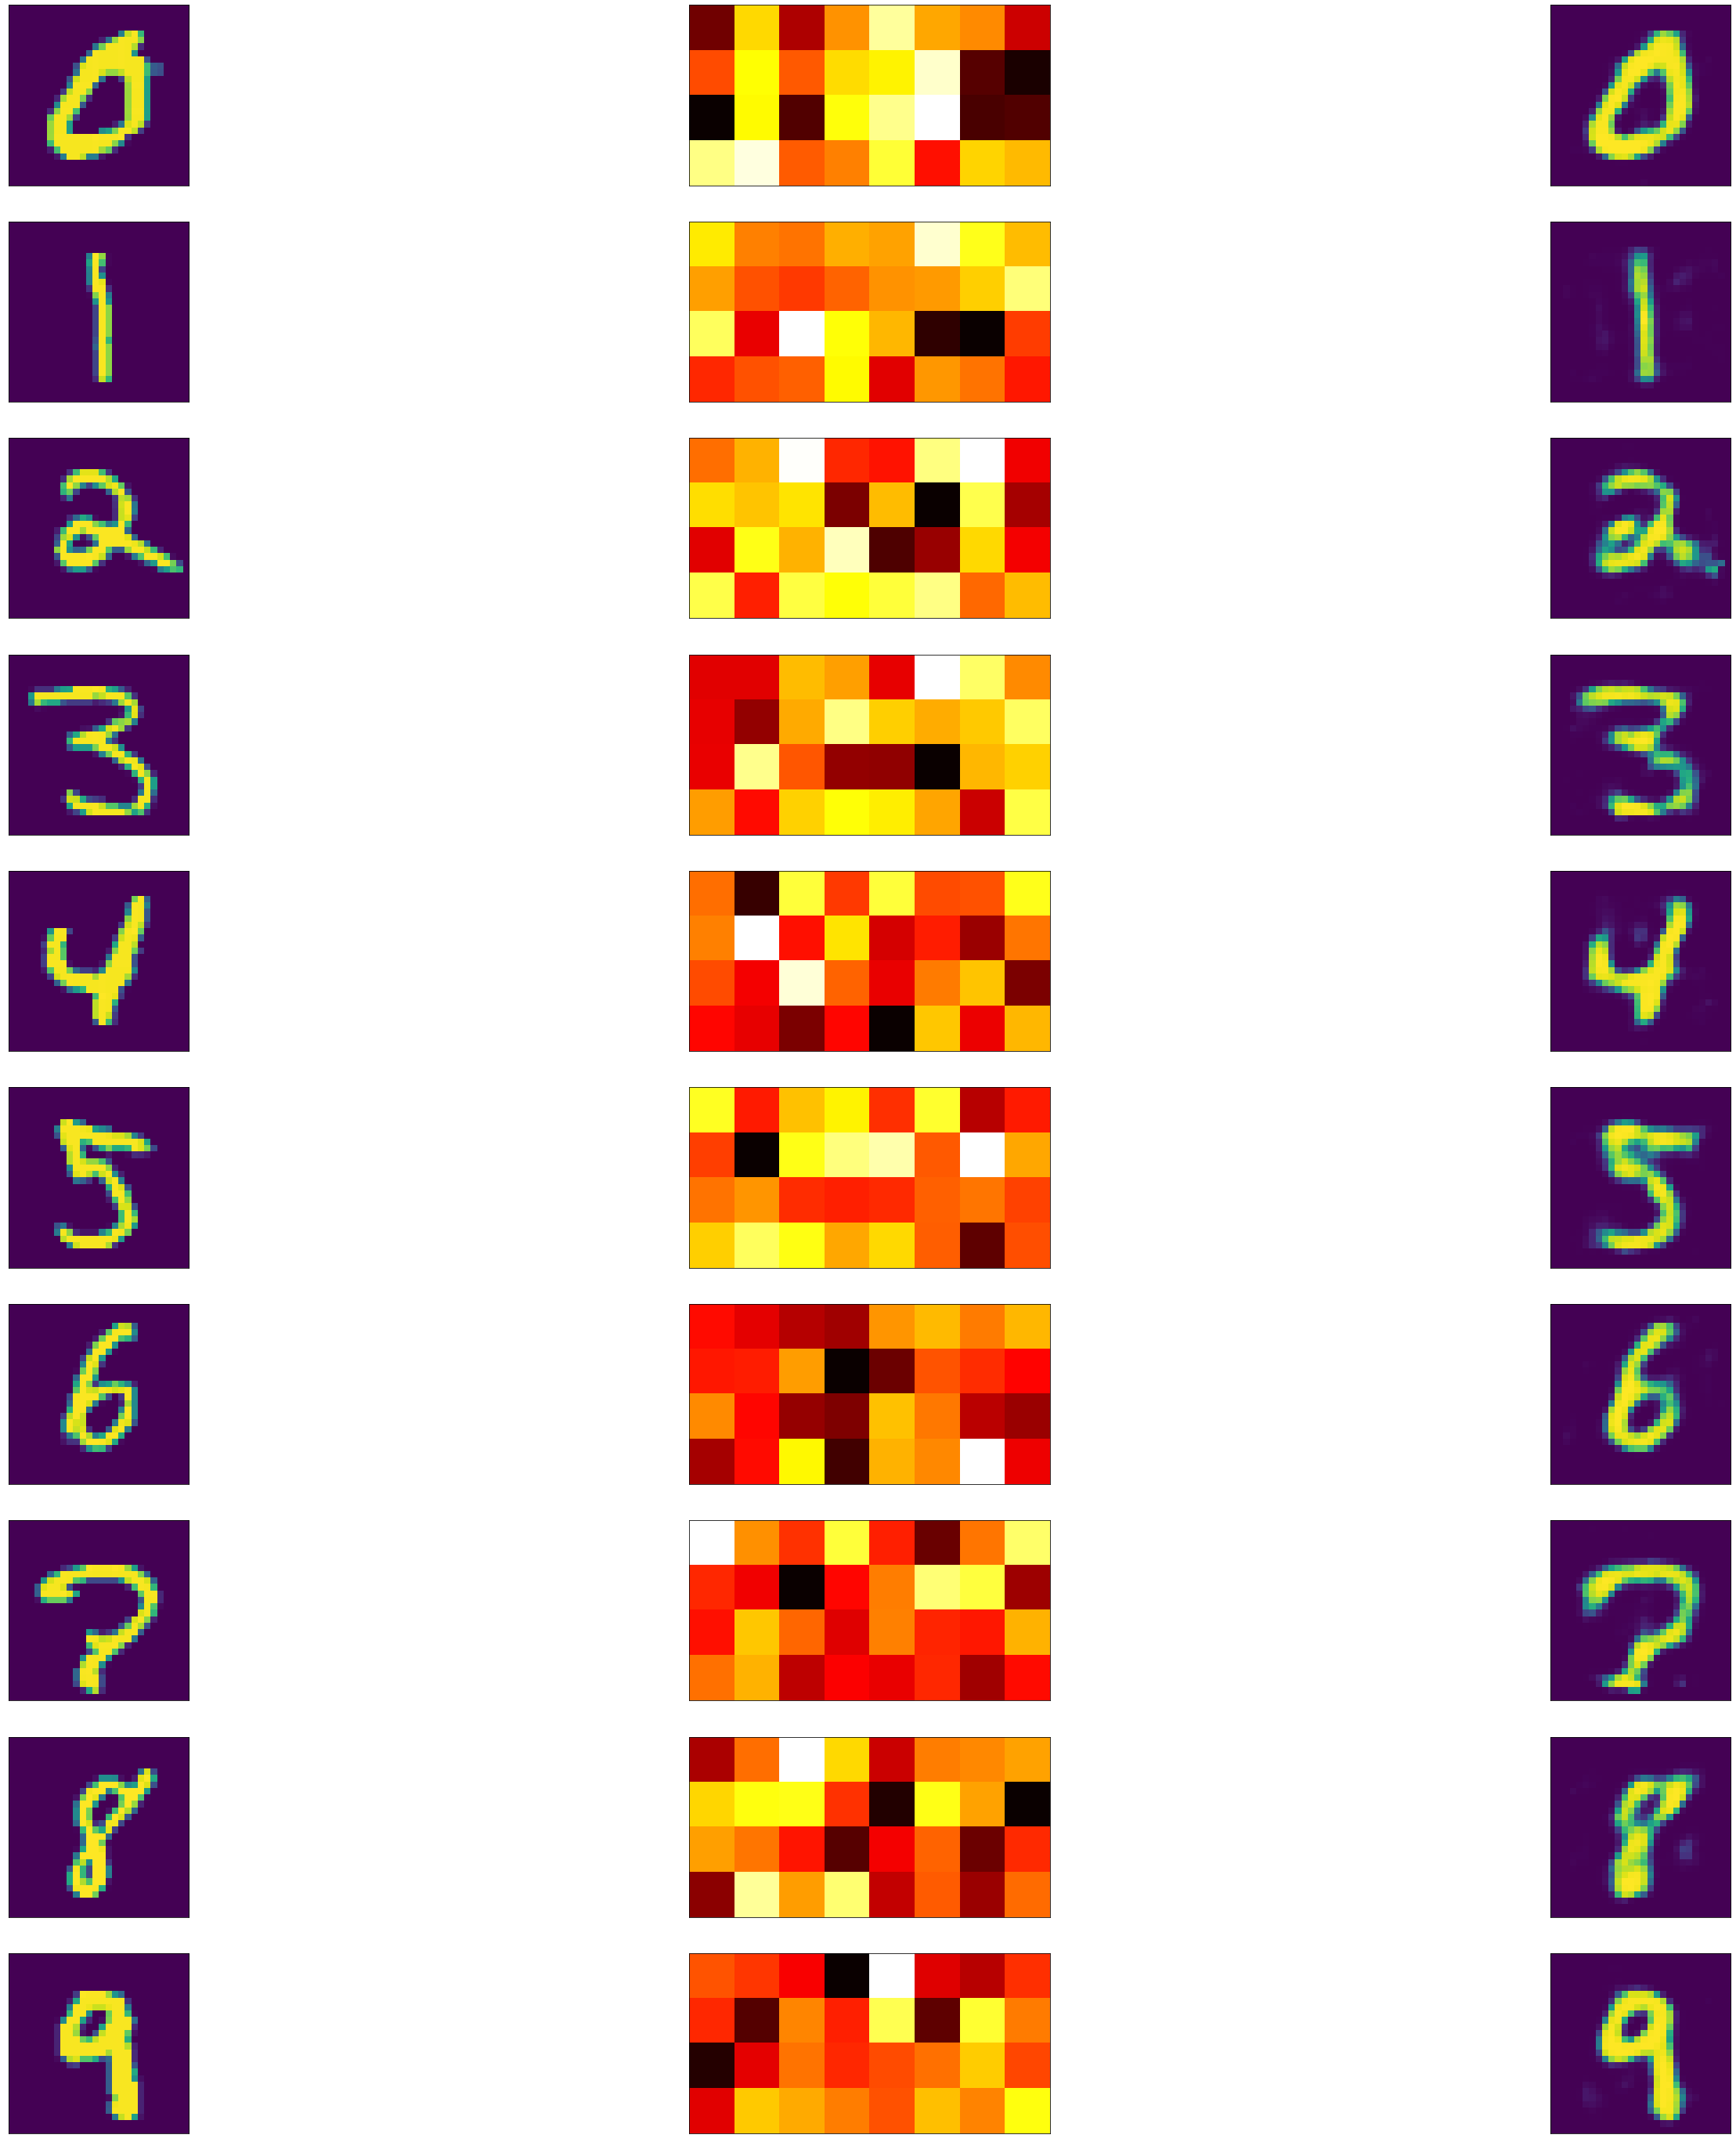

In [90]:
import random


def get_img(number, images, labels):
    labels = np.argmax(labels, axis=1)
    i = np.where(labels == number)
    return random.choice(images[i])

fig, ax = plt.subplots(10,3, figsize=(50,50))
for i in range(10):
    img = get_img(i, test_images, test_labels)
    ax[i,0].imshow(img)
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    code = encoder.predict(img[None])
    
    if(code.shape[-1] > 16):
        
        ax[i,1].imshow(code.reshape((4, code.shape[-1]//4)), cmap='hot')
    else:
        ax[i,1].imshow(code, cmap='hot')
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
    reconstruction = decoder.predict(code)
    ax[i,2].imshow(reconstruction[0])
    ax[i,2].get_xaxis().set_visible(False)
    ax[i,2].get_yaxis().set_visible(False)
